In [1]:
#@title Installing needed dependencies!
from IPython.display import clear_output
try:
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib as mplt
    import pandas as pd
    import numpy as np
    import os
    import sys
    import string
    import re
    import nltk
    from nltk import ngrams
    from unidecode import unidecode
    #from nltk.corpus import stopwords

    print("Modules required are already installed!")
except ModuleNotFoundError:
    %pip install networkx
    clear_output()
    %pip install matplotlib
    clear_output()
    %pip install pandas
    clear_output()
    %pip install nltk
    clear_output()
    %pip install unidecode
    clear_output()

    print("All modules required were sucessfully installed!")

Modules required are already installed!


/tmp/ipykernel_10024/1812064981.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


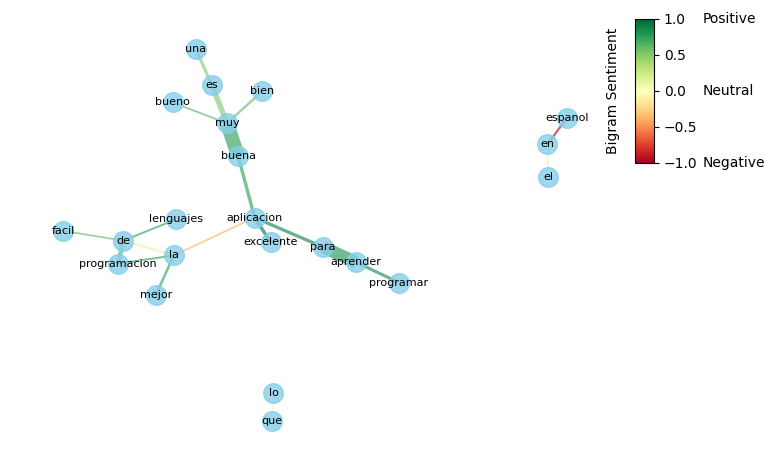

In [8]:
#@title Plot Top K Most Frequent Bigrams of App Reviews

#@markdown **Data**

#@markdown * ### Pick language:
language = "Spanish" #@param ["English", "Spanish"]

#@markdown * ### Pick store (There are no Spanish App Store reviews):
store = "Google Play Store" #@param ["App Store", "Google Play Store"]

#@markdown * ### Pick app:
app = "sololearn" #@param ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "python-x", "sololearn"]

#@markdown * ### How many bigrams?
bigram_count = 20 #@param {type:"number"}

#@markdown * ### Add any words to exclude as a comma separated list
exclude_words = "app , learn" #@param {type:"string"}
exclude_list = [word.strip() for word in exclude_words.split(',')]

#@markdown **Graph Appearance**

#@markdown * ### Scale edge widths with bigram frequency?
edge_width_change = 'Yes' #@param ["Yes", "No"]

#@markdown * ### Scale edge colors with bigram sentiment?
edge_color_change = 'Yes' #@param ["Yes", "No"]

#@markdown * ### Layout:
graph_layout = 'Fruchterman-Reingold' #@param ["Fruchterman-Reingold", "Spring"]

#@markdown * ### Optimal distance between nodes:
node_distance = 3 #@param {type:"number"}


dir = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/bigram-network/"
#dir = "./"

if language == 'English':

  # Reviews from different stores are named differently and in different folders
  if store == "App Store":
    dir += "applestore-review-files-standardized/"
    reviewfile = "applestore-review-" + app + "_sentiment_standardized.csv"
  else:
    dir += "googleplay-review-files-standardized/"
    reviewfile = "googleplay-review-" + app + "_sentiment_standardized.csv"

elif language == 'Spanish':

  #   # Reviews from different stores are named differently and in different folders
  # if store == "App Store":
  #   dir += "applestore-review-files-standardized_Spanish/"
  #   reviewfile = "applestore-review-" + app + "_Spanish_sentiment_standardized.csv"
  # else:
  dir += "googleplay-review-files-standardized_Spanish/"
  reviewfile = "googleplay-review-" + app + "_Spanish_sentiment_standardized.csv"

df = pd.read_csv(dir + reviewfile)
#df = pd.read_csv('/applestore-review-codeacademy_sentiment_standardized.csv')

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove diacritics and accents
    text = unidecode(text)

    # Tokenization
    text = text.split()

    # Remove stopwords
    #stop_words = set(stopwords.words("english"))
    #text = [word for word in text if word not in stop_words]

    # Return the standardized string
    #return ' '.join(text)

    return text

# Removing stopwords and tokenizing
df['standardizedReview'] = df['standardizedReview'].astype('str')
df['standardizedReview'] = df['standardizedReview'].apply(preprocess) 

if language == 'English':
  # Assigning numerical value to sentiment
  df['sentimentScore'] = df['sentiment'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}) 
elif language == 'Spanish':
  df['sentimentScore'] = df['sentiment'].map({'POS': 1, 'NEU': 0, 'NEG': -1}) 


# Generate bigrams for each review
df['bigrams'] = df['standardizedReview'].apply(lambda x: list(ngrams(x, 2)))
bigram_frequency = df['bigrams'].explode().value_counts().to_dict()

bigram_frequency = {bigram: frequency for bigram, frequency in bigram_frequency.items()
                    if all(word not in bigram for word in exclude_list)}

# Get the top k bigrams
sorted_bigrams = sorted(bigram_frequency.items(), key=lambda x: x[1], reverse=True)
filtered_bigrams = dict(sorted_bigrams[:bigram_count])

bigram_sentiment = df.explode('bigrams').groupby('bigrams')['sentimentScore'].mean().to_dict()



# Create a network graph
G = nx.Graph()

# Add nodes for unigrams and bigrams
# for unigram in df['standardizedReview'].explode().unique():
#     G.add_node(unigram)

# for bigram in filtered_bigrams:
#     G.add_node(bigram)

# Add edges with size and color attributes
for bigram, frequency in filtered_bigrams.items():
    sentiment = bigram_sentiment.get(bigram, 0.0)
    G.add_edge(bigram[0], bigram[1], weight=frequency, sentiment=sentiment)

# Set edge sizes based on frequency and edge colors based on sentiment
edge_sizes = [data['weight'] for _, _, data in G.edges(data=True)]
# min_size = min(edge_sizes)
# edge_sizes = [size - min_size for size in edge_sizes]
# edge_sizes = [size/10 for size in edge_sizes]
edge_colors = [data['sentiment'] for _, _, data in G.edges(data=True)]

# Normalize edge sizes for more regular edge widths when plotting
min_val = np.min(edge_sizes)
max_val = np.max(edge_sizes)

# Define the target range
target_min = 1
target_max = 10

# Perform min-max scaling on each list
edge_sizes = [(target_max - target_min) * (lst - min_val) / (max_val - min_val) + target_min for lst in edge_sizes]

# Position nodes using a layout algorithm (e.g., spring layout)
if graph_layout == 'Fruchterman-Reingold':
  pos = nx.spring_layout(G, k=node_distance)
elif graph_layout == 'Spring':
  pos = nx.fruchterman_reingold_layout(G, k=node_distance)

# Draw nodes, edges, labels, and adjust visual parameters
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.8)

if edge_color_change == 'Yes':

  if edge_width_change == 'Yes':
    nx.draw_networkx_edges(G, pos, width=edge_sizes, edge_color=edge_colors, edge_cmap=plt.cm.RdYlGn, alpha=0.6)
  else:
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.RdYlGn, alpha=0.6)

else:

  if edge_width_change == 'Yes':
    nx.draw_networkx_edges(G, pos, width=edge_sizes, edge_color='grey', edge_cmap=plt.cm.RdYlGn, alpha=0.6)
  else:
    nx.draw_networkx_edges(G, pos, edge_color='grey', edge_cmap=plt.cm.RdYlGn, alpha=0.6)

nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.axis('off')

if edge_color_change == 'Yes':

  # Create colorbar legend
  sm = plt.cm.ScalarMappable(cmap=mplt.colormaps['RdYlGn'], norm=plt.Normalize(vmin=-1, vmax=1))
  sm.set_array([])
  cbar_ax = plt.gcf().add_axes([1, 0.65, 0.03, 0.3])  # Adjust the position and size of the colorbar axes
  cbar = plt.colorbar(sm, cax=cbar_ax, shrink=0.5)  # Assign the colorbar axes

  # Rotate the colorbar label
  cbar.ax.yaxis.set_label_coords(-1.5, 3)
  cbar.ax.set_ylabel('Bigram Sentiment')

  # Add labels next to colorbar
  plt.text(3.5, 1, 'Positive', ha='left', va='center')
  plt.text(3.5, 0, 'Neutral', ha='left', va='center')
  plt.text(3.5, -1, 'Negative', ha='left', va='center')

# Display the visualization
plt.tight_layout()
plt.show()
